In [50]:
import os
import torch
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm, multivariate_normal
from tqdm import tqdm

from sklearn.metrics import r2_score, root_mean_squared_error

from models.fno import FNO
from models.losses import LpLoss, H1Loss

In [51]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
data_dir = 'data/'

In [4]:
directories = os.listdir('data')
directories

['-15.97_3.30',
 '17.62_4.03',
 '0.13_2.14',
 '7.41_2.62',
 '-7.62_2.88',
 '-6.03_4.22',
 '-5.48_3.54',
 '-1.41_5.00',
 '-16.58_4.83',
 '-2.08_3.11',
 '-3.52_4.72']

In [5]:
datasets = []

for directory in directories:
    ax_path = os.path.join(data_dir, directory, 'ax.pt')
    ux_path = os.path.join(data_dir, directory, 'ux_analytic.pt')
    ax = torch.load(ax_path, map_location=torch.device('cpu'))
    ux = torch.load(ux_path, map_location=torch.device('cpu'))
    datasets.append({'ax': ax,
                     'ux': ux})


In [6]:
n_dataset = len(datasets)
n_dataset

11

In [8]:
from torch.utils.data import Dataset, TensorDataset, DataLoader

In [9]:
class DictDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        return {'x': x, 'y': y}
    
    def __len__(self):
        return len(self.data)

In [10]:
def training_loop(model, train_dl, train_loss, optimizer, scheduler, n_epochs=500):

    train_losses = []
    test_losses = []

    for epoch in tqdm(range(n_epochs)):

        avg_loss = 0
        avg_lasso_loss = 0
        model.train()
        train_err = 0.0

        avg_test_loss = 0
        test_err = 0.0

        for idx, sample in enumerate(train_dl):

            # load everything from the batch onto self.device if 
            # no callback overrides default load to device

            for k,v in sample.items():
                if hasattr(v, 'to'):
                    sample[k] = v.to(device)

            optimizer.zero_grad(set_to_none=True)
            out = model(**sample)

            loss = 0.

            if isinstance(out, torch.Tensor):
                loss = train_loss(out.float(), **sample)
            elif isinstance(out, dict):
                loss += train_loss(**out, **sample)

            del out

            loss.backward()

            optimizer.step()
            train_err += loss.item()

            with torch.no_grad():
                avg_loss += loss.item()

        if (epoch + 1) % 5:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(train_err)
            else:
                scheduler.step()

        train_err /= len(train_dl)
        avg_loss  /= n_epochs


        train_losses.append(avg_loss)
        # test_losses.append(avg_test_loss)

        # print(f'Epoch: {epoch+1} loss: {avg_loss:.4f}  test loss: {avg_test_loss:.4f} lr: {scheduler.get_last_lr()[0]:.4f}, {optimizer.state_dict()["param_groups"][0]["lr"]:.4f}')
        if (epoch + 1) == n_epochs:
            print(f'Epoch: {epoch+1} loss: {avg_loss:.4f} lr: {scheduler.get_last_lr()[0]:.4f}, {optimizer.state_dict()["param_groups"][0]["lr"]:.4f}')
        
    return model

In [11]:
def train_model(train_loader, n_modes=(16, 10), in_channels=2, hidden_channels=64, 
                 projection_channels=64, n_epochs=200):
    
    # Losses
    l2loss = LpLoss(d=2, p=2)
    h1loss = H1Loss(d=2)

    train_loss = h1loss
    eval_losses={'h1': h1loss, 'l2': l2loss}
    
    # Model configuration
    n_modes = n_modes
    model = FNO(n_modes=n_modes, in_channels=in_channels, hidden_channels=hidden_channels, 
                 projection_channels=projection_channels).double()
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=1e-3,
                                weight_decay=1e-4)
    
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    
    model = training_loop(model, train_loader, 
                          train_loss, optimizer, 
                          scheduler, n_epochs=n_epochs)
    
    return model

In [73]:
def plot_results(ax, ux, ux_hat, filepath):

    # Extents
    xmin, xmax = ax[0, 0].min(), ax[0].max()
    ymin, ymax = ax[1, :, 0].min(), ax[1, :, 0].max()

    fig, axes = plt.subplots(1, 4, figsize=(18, 3))
    
    im = axes[0].imshow(ax[2], extent=(xmin, xmax, ymin, ymax), origin='lower')
    axes[0].set_title('$h(x)$')
    fig.colorbar(im, orientation='vertical')
    
    
    im = axes[1].imshow(ax[3], extent=(xmin, xmax, ymin, ymax), origin='lower')
    axes[1].set_title('$p(x)$')
    fig.colorbar(im, orientation='vertical')
    
    im = axes[2].imshow(ux[0], extent=(xmin, xmax, ymin, ymax), origin='lower')
    axes[2].set_title('$\phi(x)$')
    fig.colorbar(im, orientation='vertical')
    
    im = axes[3].imshow(ux_hat[0], vmax=ux.max(), vmin=ux.min(), 
                        extent=(xmin, xmax, ymin, ymax), origin='lower')
    axes[3].set_title('$\phi_{pred}(x)$')
    fig.colorbar(im, orientation='vertical')

    # fig.savefig(filepath, bbox_inches='tight')

    return fig

In [74]:
def validate(model, val_dataset, directory, interpolate=True):
    val_ax = val_dataset['ax']
    val_ux = val_dataset['ux']
    
    l2loss = LpLoss(d=2, p=2)
    h1loss = H1Loss(d=2)
    
    with torch.no_grad():
        ϕx_hat = model(val_ax.to(device))
        error = h1loss(ϕx_hat, val_ux.to(device))
        print(f"Validation H1Loss: {error.item():.2f}")

    ϕx_hat = ϕx_hat.reshape((10, 10, 1, 32, 32))

    if interpolate:
        for i in range(2, 9, 2):
            for j in range(2, 9, 2):
                ϕx_hat[i, j, :, :, :16] = (ϕx_hat[i, j, :, :, :16] + ϕx_hat[i, j-1, :, :, 16:])/2
                ϕx_hat[i, j, :, :, 16:] = (ϕx_hat[i, j, :, :, 16:] + ϕx_hat[i, j+1, :, :, :16])/2
                ϕx_hat[i, j, :, :16, :] = (ϕx_hat[i, j, :, :16, :] + ϕx_hat[i-1, j, :, 16:, :])/2
                ϕx_hat[i, j, :, 16:, :] = (ϕx_hat[i, j, :, 16:, :] + ϕx_hat[i+1, j, :, :16, :])/2
            

    # skip alternate rows and cols
    ϕx_hat = ϕx_hat[::2, ::2].cpu().numpy()
    val_ax = val_ax.reshape((10, 10, 4, 32, 32))[::2, ::2].numpy()
    val_ux = val_ux.reshape((10, 10, 1, 32, 32))[::2, ::2].numpy()

    r2_error = r2_score(val_ux.flatten(), ϕx_hat.flatten())
    rmse = root_mean_squared_error(val_ux.flatten(), ϕx_hat.flatten())

    # ux_hat
    ϕx_hat = np.concatenate([ϕx_hat[:, i] for i in range(5)], axis=-1)
    ϕx_hat = np.concatenate([ϕx_hat[i] for i in range(5)], axis=-2)
    
    # ax
    val_ax = np.concatenate([val_ax[:, i] for i in range(5)], axis=-1)
    val_ax = np.concatenate([val_ax[i] for i in range(5)], axis=-2)
    
    # ux
    val_ux = np.concatenate([val_ux[:, i] for i in range(5)], axis=-1)
    val_ux = np.concatenate([val_ux[i] for i in range(5)], axis=-2)

    # plot results
    plot_results(val_ax, val_ux, ϕx_hat, filepath=f'plots/{directory}.png')
    
    return error.item(), r2_error, rmse

100%|██████████| 200/200 [01:09<00:00,  2.88it/s]

Epoch: 200 loss: 0.1352 lr: 0.0002, 0.0002
Validation H1Loss: 37.03
Validation H1Loss: 37.03


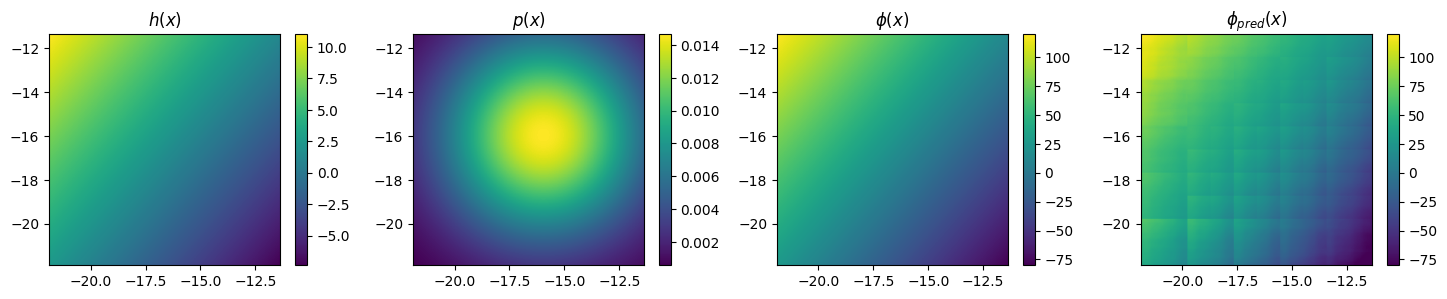

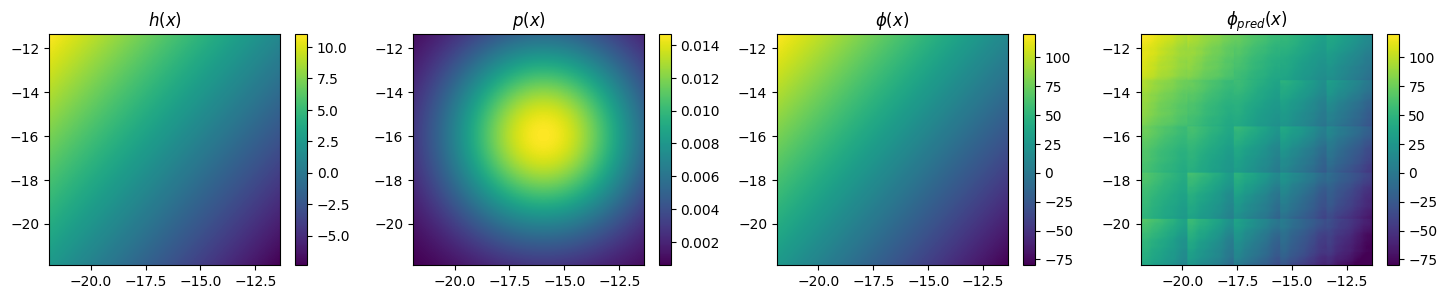

In [75]:
res_list = []
for k in range(n_dataset):
    train_dataset = {}
    train_dataset['ax'] = torch.concat([datasets[i]['ax'] for i in range(n_dataset) if i!=k], dim=0)
    train_dataset['ux'] = torch.concat([datasets[i]['ux'] for i in range(n_dataset) if i!=k], dim=0)
    val_dataset = datasets[k]
    
    train_ds = DictDataset(train_dataset['ax'], train_dataset['ux'])
    train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
    
    model = train_model(train_dl, in_channels=4, n_modes=(8, 8), n_epochs=200)
    
    h1_error, r2_error, rmse = validate(model, val_dataset, 
                                        directory=directories[k], 
                                        interpolate=True)
    h1_error, r2_error_noint, rmse_noint = validate(model, val_dataset, 
                                                    directory=f'{directories[k]}_noint',  
                                                    interpolate=False)

    μ, σ = list(map(float, directories[k].split('_')))
    
    res = {'$\mu$': μ,
           '$\sigma$': σ,
           'h1_error': h1_error,
           'r2_int': r2_error,
           'r2_noint': r2_error_noint,
           'rmse_int': rmse,
           'rmse_noint': rmse_noint}
    
    res_list.append(res)
    break

In [66]:
res

{'$\\mu$': -15.97,
 '$\\sigma$': 3.3,
 'h1_error': 29.471821366097796,
 'r2_int': 0.9668985408561006,
 'r2_noint': 0.9639948926053583,
 'rmse_int': np.float64(7.479509577911848),
 'rmse_noint': np.float64(7.800664664524184)}

In [ ]:
res_df = pd.DataFrame(res_list)
res_df.to_csv('results.csv', index=False)